# 1.Version

In [1]:
import tensorflow as tf
print(tf.__version__)

#https://github.com/adapt-python/adapt/issues/118


2.15.0


# 2.Imports 

In [2]:
# Importing the required packages
import pandas as pd
import numpy as np
import os, shutil
import math
import matplotlib.pyplot as plt

import urllib.request
from tqdm import tqdm
from PIL import Image
import cv2
import pickle


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from keras.metrics import F1Score

import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, Model #-> Versão 2.12
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D, GlobalAveragePooling2D, concatenate #-> Versão 2.12
from tensorflow.keras.optimizers import RMSprop, Adam #-> Versão 2.12
from tensorflow.keras.applications import VGG16, ResNet101, ResNet101V2, InceptionV3
import keras.backend as K
from tensorflow.keras.models import load_model 
from tensorflow.keras.utils import to_categorical



- **md5hash**: A unique identifier for each image.
- **fitzpatrick_scale**: The Fitzpatrick scale value for the skin type in the image.
- **fitzpatrick_centaur**: Another scale related to the Fitzpatrick scale, potentially adjusted or annotated differently.
- **label**: The target variable indicating the skin condition diagnosed in the image.
- **nine_partition_label** and **three_partition_label**: These columns seem to categorize conditions into broader groups.
- **qc**: A column that might relate to quality control or other annotations, which is empty in the first few rows.
- **url**: The URL of the image of the skin lesion.
- **url_alphanum**: A version of the URL with only alphanumeric characters, likely for easier processing or identification.


In [3]:
# Getting the current working directory
directory = os.getcwd()
directory

'c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project'

# 3.Images DownLoad and Preprocessing

In [4]:
df = pd.read_csv('c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project\\fitzpatrick17k.csv', sep=',')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                16577 non-null  object
 1   fitzpatrick_scale      16577 non-null  int64 
 2   fitzpatrick_centaur    16577 non-null  int64 
 3   label                  16577 non-null  object
 4   nine_partition_label   16577 non-null  object
 5   three_partition_label  16577 non-null  object
 6   qc                     504 non-null    object
 7   url                    16536 non-null  object
 8   url_alphanum           16577 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB


In [6]:
df['url'].isna().sum()

41

In [7]:
# Dropping the rows with missing values
df.dropna(subset=['url'], inplace=True)

In [8]:
def download_images_and_check_missing(df, target_dir): 
    total_missing_url = 0
    total_url_not_found = 0
    total_failed_downloads = 0
    total_downloaded = 0

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'
    }

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        if pd.isnull(row['url']):
            total_missing_url += 1
            continue
        
        url = row['url']
        filename = os.path.join(target_dir, f"{row['md5hash']}.jpg")

        if os.path.exists(filename):
            total_downloaded += 1
            continue

        req = urllib.request.Request(url, headers=headers)

        try:
            with urllib.request.urlopen(req) as response, open(filename, 'wb') as out_file:
                data = response.read()
                out_file.write(data)
                total_downloaded += 1
        except urllib.error.HTTPError as e:
            if e.code == 404:
                total_url_not_found += 1
                print(f"URL not found {url}, skipping.")
            else:
                total_failed_downloads += 1
                print(f"Failed to download {url}: HTTP Error {e.code}")
        except Exception as e:
            total_failed_downloads += 1
            print(f"Failed to download {url}: {str(e)}")

    print(f"Total de imagens com URL faltando: {total_missing_url}")
    print(f"Total de URLs não encontradas (HTTP 404): {total_url_not_found}")
    print(f"Total de falhas no download: {total_failed_downloads}")
    print(f"Total de imagens baixadas ou já presentes: {total_downloaded}")

# Supondo que 'df' é o seu DataFrame e 'images' é o seu diretório de destino
download_images_and_check_missing(df, 'images')


 78%|███████▊  | 12978/16536 [00:06<00:06, 585.74it/s] 

URL not found http://atlasdermatologico.com.br/img?imageId=6724, skipping.


 80%|███████▉  | 13200/16536 [00:07<00:08, 379.90it/s]

URL not found http://atlasdermatologico.com.br/img?imageId=4030, skipping.
URL not found http://atlasdermatologico.com.br/img?imageId=5399, skipping.
URL not found http://atlasdermatologico.com.br/img?imageId=4505, skipping.


 82%|████████▏ | 13614/16536 [00:11<00:13, 217.71it/s]

URL not found http://atlasdermatologico.com.br/img?imageId=8362, skipping.


 83%|████████▎ | 13771/16536 [00:12<00:14, 189.23it/s]

URL not found http://atlasdermatologico.com.br/img?imageId=4031, skipping.


 84%|████████▍ | 13883/16536 [00:13<00:16, 160.64it/s]

URL not found http://atlasdermatologico.com.br/img?imageId=8363, skipping.


 87%|████████▋ | 14377/16536 [00:15<00:08, 252.92it/s]

URL not found http://atlasdermatologico.com.br/img?imageId=2767, skipping.


 94%|█████████▍| 15511/16536 [00:16<00:02, 502.77it/s]

URL not found http://atlasdermatologico.com.br/img?imageId=2766, skipping.


 97%|█████████▋| 16052/16536 [00:18<00:00, 504.69it/s]

URL not found http://atlasdermatologico.com.br/img?imageId=8364, skipping.


100%|██████████| 16536/16536 [00:18<00:00, 901.56it/s]

Total de imagens com URL faltando: 0
Total de URLs não encontradas (HTTP 404): 10
Total de falhas no download: 0
Total de imagens baixadas ou já presentes: 16526


Since we have 41 missing URLs and 10 that aren't valid we are going to drop this rows.

In [9]:
invalid_urls = [
    "http://atlasdermatologico.com.br/img?imageId=6724",
    "http://atlasdermatologico.com.br/img?imageId=4030",
    "http://atlasdermatologico.com.br/img?imageId=5399",
    "http://atlasdermatologico.com.br/img?imageId=4505",
    "http://atlasdermatologico.com.br/img?imageId=8362",
    "http://atlasdermatologico.com.br/img?imageId=4031",
    "http://atlasdermatologico.com.br/img?imageId=8363",
    "http://atlasdermatologico.com.br/img?imageId=2767",
    "http://atlasdermatologico.com.br/img?imageId=2766",
    "http://atlasdermatologico.com.br/img?imageId=8364"
]

df = df[~df['url'].isin(invalid_urls)]

In [10]:
# Path to the directory containing the images
images_dir = 'c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project\\images'

# List of problematic images
problematic_images = []

# Verify the integrity of each image
for filename in tqdm(os.listdir(images_dir)):
    if not filename.endswith('.jpg'):  # Ignore non-image files
        continue
    
    try:
        img_path = os.path.join(images_dir, filename)
        with Image.open(img_path) as img:
            img.verify()  # Try to open the image and check for any errors
    except Exception as e:
        print(f"Erro ao verificar a imagem {filename}: {e}")
        problematic_images.append(filename)

# Print the total number of problematic images
print(f"Total de imagens problemáticas: {len(problematic_images)}")


100%|██████████| 16526/16526 [00:23<00:00, 702.51it/s]

Total de imagens problemáticas: 0


In [11]:
base_dir = "images"

# Define the subdirectories
train_dir = "POPULATION\\train"
val_dir = "POPULATION\\val"
test_dir = "POPULATION\\test"

# Check if directories already exist
if not (os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir)):
    # Create the directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Split the data into train, validation, and test sets
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1

    df_train_val, df_test = train_test_split(df, test_size=test_ratio, stratify=df['label'], random_state=42)
    df_train, df_val = train_test_split(df_train_val, test_size=val_ratio/(train_ratio+val_ratio), stratify=df_train_val['label'], random_state=42)

    # Function to copy images to respective directories
    def copy_images(df, dest_dir):
        for _, row in df.iterrows():
            file_name = f"{row['md5hash']}.jpg"
            source_path = os.path.join(base_dir, file_name)

            if not os.path.isfile(source_path):
                print(f"File not found: {source_path}")
                continue

            label_dir = os.path.join(dest_dir, row['label'])
            os.makedirs(label_dir, exist_ok=True)

            destination_path = os.path.join(label_dir, file_name)
            shutil.copy(source_path, destination_path)

    copy_images(df_train, train_dir)
    copy_images(df_val, val_dir)
    copy_images(df_test, test_dir)


# Function to count images in a directory
def count_images(dir_path):
    count = 0
    for _, dirs, files in os.walk(dir_path):
        count += len(files)
    return count

print(f"Total images in training: {count_images(train_dir)}")
print(f"Total images in validation: {count_images(val_dir)}")
print(f"Total images in testing: {count_images(test_dir)}")

Total images in training: 13220
Total images in validation: 1653
Total images in testing: 1653


Slide 21 Class_3_MLF
- the lower the loss on training data, the lower the loss on test data. While this is happening, your model is said to be underfit: there is still progress to be made; the network hasn’t yet modeled all relevant patterns in the training data. 

- But after a certain number of iterations on the training data, generalization stops improving, and validation metrics stall and then begin to degrade: the model is starting to overfit. That is, it’s beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.


# 4.Functions

In [12]:
def training_plots(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1_metric']  
    val_f1 = history.history['val_f1_metric'] 

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation F1 score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1, 'bo', label='Training F1 Score')
    plt.plot(epochs, val_f1, 'b', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures

- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally

- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such 
values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.

- shear_range is for randomly applying shearing transformations

- zoom_range is for randomly zooming inside pictures

- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [13]:
import matplotlib.pyplot as plt

def training_plots_1(history):
    # Já é um dicionário, não precisa de '.history'
    acc = history['categorical_accuracy']
    val_acc = history['val_categorical_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    f1 = history['f1_metric']
    val_f1 = history['val_f1_metric']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation F1 score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1, 'bo', label='Training F1 Score')
    plt.plot(epochs, val_f1, 'b', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [14]:
def evaluate_model(model, train_generator, validation_generator, test_generator):
    # Evaluate the model on the training set
    train_results = model.evaluate(train_generator, verbose=0)
    train_loss, train_categorical_accuracy, train_f1_metric = train_results  # Adjusted for additional metric
    
    # Evaluate the model on the validation set
    validation_results = model.evaluate(validation_generator, verbose=0)
    validation_loss, validation_categorical_accuracy, validation_f1_metric = validation_results  # Adjusted for additional metric

    # Evaluate the model on the validation set
    test_results = model.evaluate(test_generator, verbose=0)
    test_loss, test_categorical_accuracy, test_f1_metric = test_results  # Adjusted for additional metric
    
    # Print Loss, Categorical Accuracy, and Weighted F1 Score for Training and Validation Sets
    print(f"Training Loss: {train_loss}\nTraining Categorical Accuracy: {train_categorical_accuracy}\nTraining Weighted F1-score: {train_f1_metric}")
    print(f"Validation Loss: {validation_loss}\nValidation Categorical Accuracy: {validation_categorical_accuracy}\nValidation Weighted F1-score: {validation_f1_metric}")
    print(f"Test Loss: {test_loss}\nTest Categorical Accuracy: {test_categorical_accuracy}\nTest Weighted F1-score: {test_f1_metric}")


https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras/45305384#45305384

In [15]:
#https://stackoverflow.com/questions/59963911/how-to-write-a-custom-f1-loss-function-with-weighted-average-for-keras
from tensorflow.keras import backend as K

def f1_metric(true, pred):
    # predLabels = K.argmax(pred, axis=-1)  # Uncomment these lines if 'pred' needs to be converted
    # pred = K.one_hot(predLabels, 4)      # from probabilities to one-hot encoded values

    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)
    
    return weighted_f1  # Return the weighted F1 score directly


# 5.Rescaling

https://www.ibm.com/topics/underfitting

Identifying overfitting can be more difficult than underfitting because unlike underfitting, the training data performs at high accuracy in an overfitted model. To assess the accuracy of an algorithm, a technique called k-fold cross-validation is typically used.


In [16]:
# # Rescale all images by 1./255
# # CNNs_TF2 Slide 96
# #https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],  # Adjust brightness randomly between 0.5 and 1.5
    channel_shift_range=20,  # Randomly shift channels by up to 20 intensity units
    )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# # Rescale all images by 1./255
# # CNNs_TF2 Slide 96
# #https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# from keras.layers import CenterCrop

# train_datagen = ImageDataGenerator(rescale=1./255 #Need to divide by 255 to normalize the pixel values [0, 255] to [0, 1]
#                                    , rotation_range=30 #Rotate the image by 30 degrees
#                                    , width_shift_range=0.2 #Shift the image horizontally by 20%
#                                    , height_shift_range=0.2 #Shift the image vertically by 20%
#                                    , shear_range=0.2 #Shear the image by 20%
#                                    , zoom_range=0.2 #Zoom in by 20%
#                                    #, preprocessing_function=CenterCrop(height, width)
#                                    , horizontal_flip=True) #Flip the image horizontally
# validation_datagen = ImageDataGenerator(rescale=1./255)


# 6.Train, Val and Test Generator

In [18]:
# CNNs_TF2 Slide 96
#150x150 RGB images with shape (20, 150, 150, 3)
train_generator15020 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle = True)
#150x150 RGB images with shape (32, 150, 150, 3)
train_generator15032 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = True)
#224x224 RGB images with shape (64, 224, 224, 3)
train_generator22464 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle = True)

#224x224 RGB images with shape (256, 224, 224, 3)
train_generator224256 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle = True)


Found 13220 images belonging to 114 classes.
Found 13220 images belonging to 114 classes.
Found 13220 images belonging to 114 classes.
Found 13220 images belonging to 114 classes.


In [19]:
#150x150 RGB images with shape (20, 150, 150, 3)
validation_generator15020 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle = False)

#150x150 RGB images with shape (32, 150, 150, 3)
validation_generator15032 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False)
#224x224 RGB images with shape (64, 224, 224, 3)
validation_generator22464 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle = False)
#224x224 RGB images with shape (256, 224, 224, 3)
validation_generator224256 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle = True)

Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.


In [20]:
#150x150 RGB images with shape (20, 150, 150, 3)
test_generator15020 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle = False)

#150x150 RGB images with shape (32, 150, 150, 3)
test_generator15032 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False)
#227x227 RGB images with shape (64, 227, 227, 3)
test_generator22764 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical',
    shuffle = False)
#224x224 RGB images with shape (64, 224, 224, 3)
test_generator22464 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle = False)
#224x224 RGB images with shape (256, 224, 224, 3)
test_generator224256 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle = False)



Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.


In [21]:
# For training generator
train_samples = train_generator15020.samples
train_batch_size = train_generator15020.batch_size
train_image_shape = train_generator15020.image_shape

print(f"Training: Total samples: {train_samples}, Batch size: {train_batch_size}, Image shape: {train_image_shape}")

# For validation generator
val_samples = validation_generator15020.samples
val_batch_size = validation_generator15020.batch_size
val_image_shape = validation_generator15020.image_shape

print(f"Validation: Total samples: {val_samples}, Batch size: {val_batch_size}, Image shape: {val_image_shape}")

# For test generator
test_samples = test_generator15020.samples
test_batch_size = test_generator15020.batch_size
test_image_shape = test_generator15020.image_shape

print(f"Test: Total samples: {test_samples}, Batch size: {test_batch_size}, Image shape: {test_image_shape}")
#(13221,64,64,3) 3 13221 images of 64x64 px and 3 color channels
#RGB 
#Go from 0 to 255, red is (255,0,0), green is (0,255,0) and blue is (0,0,255)

Training: Total samples: 13220, Batch size: 20, Image shape: (150, 150, 3)
Validation: Total samples: 1653, Batch size: 20, Image shape: (150, 150, 3)
Test: Total samples: 1653, Batch size: 20, Image shape: (150, 150, 3)


In [22]:
# For training generator
train_samples = train_generator15032.samples
train_batch_size = train_generator15032.batch_size
train_image_shape = train_generator15032.image_shape

print(f"Training: Total samples: {train_samples}, Batch size: {train_batch_size}, Image shape: {train_image_shape}")

# For validation generator
val_samples = validation_generator15032.samples
val_batch_size = validation_generator15032.batch_size
val_image_shape = validation_generator15032.image_shape

print(f"Validation: Total samples: {val_samples}, Batch size: {val_batch_size}, Image shape: {val_image_shape}")

# For test generator
test_samples = test_generator15032.samples
test_batch_size = test_generator15032.batch_size
test_image_shape = test_generator15032.image_shape

print(f"Test: Total samples: {test_samples}, Batch size: {test_batch_size}, Image shape: {test_image_shape}")

Training: Total samples: 13220, Batch size: 32, Image shape: (150, 150, 3)
Validation: Total samples: 1653, Batch size: 32, Image shape: (150, 150, 3)
Test: Total samples: 1653, Batch size: 32, Image shape: (150, 150, 3)


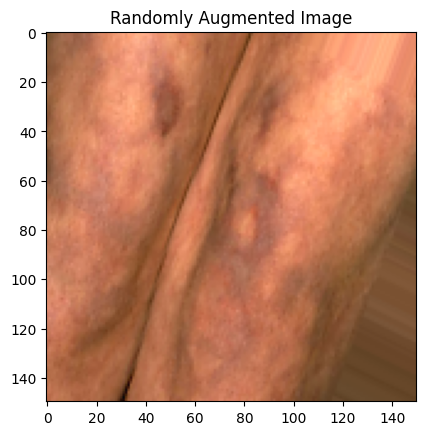

In [23]:
# Retrieve a batch of images and labels
images, labels = next(train_generator15020)

# Display the first image in the batch
plt.imshow(images[10])
plt.title('Randomly Augmented Image')
plt.show()

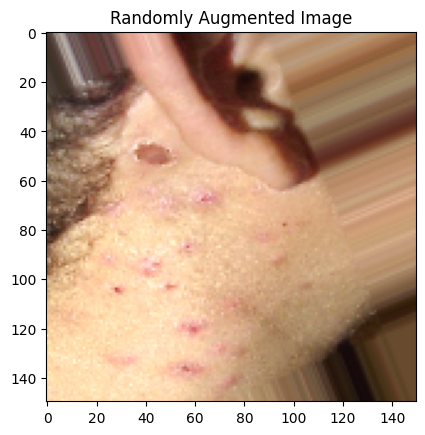

In [24]:
# Retrieve a batch of images and labels
images, labels = next(train_generator15032)

# Display the first image in the batch
plt.imshow(images[10])
plt.title('Randomly Augmented Image')
plt.show()

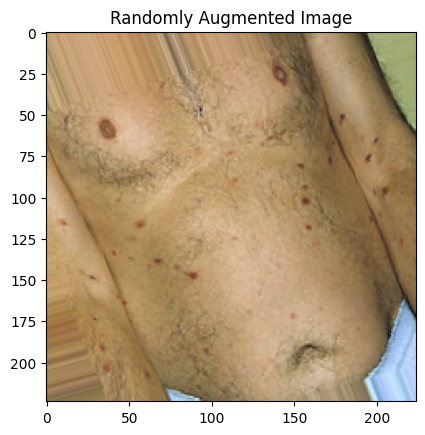

In [25]:
# Retrieve a batch of images and labels
images, labels = next(train_generator22464)

# Display the first image in the batch
plt.imshow(images[10])
plt.title('Randomly Augmented Image')
plt.show()

# 7.CallBacks - Early Stopping

https://datascience.stackexchange.com/questions/26833/is-there-away-to-change-the-metric-used-by-the-early-stopping-callback-in-keras

https://stackoverflow.com/questions/50003595/earlystopping-is-ignoring-my-custom-metrics-defined-keras-model

In [26]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_loss', 
        mode= 'min'),
]

# 8.ConvNet + AlexNet

## 8.1 ConvNet - Covered In Class (4 layers)

- Sequential Model - Layers are going to stacked up in the sequence; **First we have the convolutional layer and the maxpool** then another conv then maxpool and then we have a couple off fully conected layers, that's why is sequentially.

- The first parameter is the nr of filters that we are going to use and then the size of the filter that we want to use. Then we just need to mention the height and widht of the filter which is ex(3,3). Then we need to mention the activation function and on the first layer we need to mention the input_shape hich means what kind of shape is this model expecting.

- Then we need to define maxpool that takes only 1 parameter which is the filter size.
´
- The final step is Flatten. 
We are going to use Dense layers (which means fully connected layers) The first parameter indicates the nr of neurons that we wannt to keep in thar layer, the 2nd parameter is the activation function. Then we compute the last Dense(nr outputs as the target class, activation sigmoid [Sigmoid(2), SoftMax(<2)])


- Conv 2D Layer - https://keras.io/api/layers/convolution_layers/convolution2d/
- Padding is a technique used in convolutional neural networks (CNNs) to preserve the spatial dimensions of the input data and prevent the loss of information at the edges of the image.  It involves adding additional rows and columns of pixels around the edges of the input data. https://www.geeksforgeeks.org/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max_pool-of-tensorflow/
- MaxPool https://keras.io/api/layers/pooling_layers/max_pooling2d/
- Flatten https://keras.io/api/layers/reshaping_layers/flatten/

In [27]:
def build_classifier1(optimizers):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(units=512, activation='relu'))
    classifier.add(Dense(units=114, activation='softmax'))
    classifier.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_metric])
    return classifier


In [28]:
classifier1 = build_classifier1(optimizers.RMSprop(learning_rate=1e-4))
classifier2 = build_classifier1(optimizers.RMSprop(learning_rate=1e-4))

### 8.1.1 150x150 and batch_size = 20 and batch_size = 32, Optimizer RMSProp 

In [29]:
history1 = classifier1.fit(
    train_generator15020,
    steps_per_epoch = 661, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15020,
    validation_steps = 82 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)

In [30]:
training_plots(history1)
evaluate_model(classifier1, train_generator15020, validation_generator15020, test_generator15020)


In [31]:
# Project directory
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

# Create directory "models" inside the project directory, if it doesn't exist
models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Saved the trained model to "models"
model_path = os.path.join(models_dir, "classifier1.h5")
classifier1.save(model_path)

history_path = os.path.join(models_dir, "classifier1_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history1.history, f)


Training Loss: 3.759216070175171
Training Categorical Accuracy: 0.14810892939567566
Training Weighted F1-score: 0.06655165553092957
Validation Loss: 3.916703939437866
Validation Categorical Accuracy: 0.1173623725771904
Validation Weighted F1-score: 0.08560658991336823
Test Loss: 3.90735125541687
Test Categorical Accuracy: 0.13309134542942047
Test Weighted F1-score: 0.08885390311479568


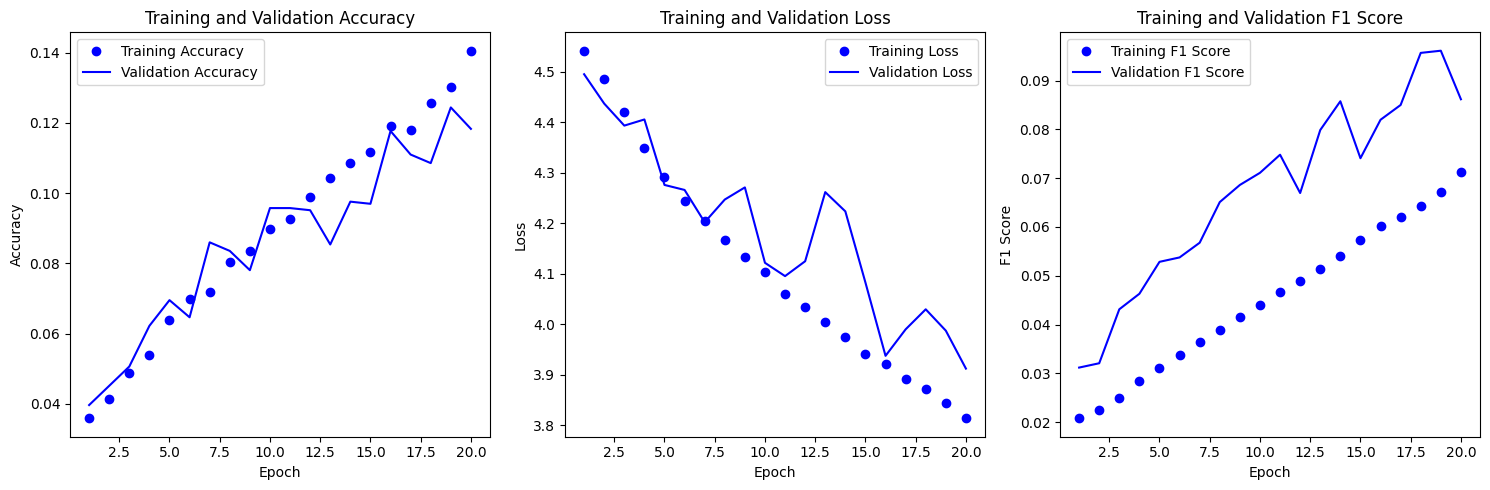

In [32]:
# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "classifier1.h5")
# history_path = os.path.join(models_dir, "classifier1_history.pkl")

# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})

# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)

# evaluate_model(classifier_loaded, train_generator15020, validation_generator15020, test_generator15020)

# training_plots_1(history_loaded)


In [33]:
#CNN_s slide 100
history2 = classifier2.fit(
    train_generator15032,
    steps_per_epoch = 413, #Calculated as the number of samples in the training set divided by the batch size, 13221 / 32 = 413.16
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15032,
    validation_steps = 51 #Calculated as the number of samples in the validation set divided by the batch size, 1653/ 32 = 51.65
)

In [34]:
# Print and Evaluate the model
training_plots(history2)
evaluate_model(classifier2, train_generator15032, validation_generator15032, test_generator15032)

In [35]:
# Project directory
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

# Create directory "models" inside the project directory, if it doesn't exist
models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Saved the trained model to "models"
model_path = os.path.join(models_dir, "classifier2.h5")
classifier2.save(model_path)

history_path = os.path.join(models_dir, "classifier2_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history2.history, f)

Training Loss: 3.8126420974731445
Training Categorical Accuracy: 0.1305597573518753
Training Weighted F1-score: 0.06295406073331833
Validation Loss: 4.168168544769287
Validation Categorical Accuracy: 0.10284331440925598
Validation Weighted F1-score: 0.08712612092494965
Test Loss: 4.146219730377197
Test Categorical Accuracy: 0.10042347013950348
Test Weighted F1-score: 0.08832471072673798


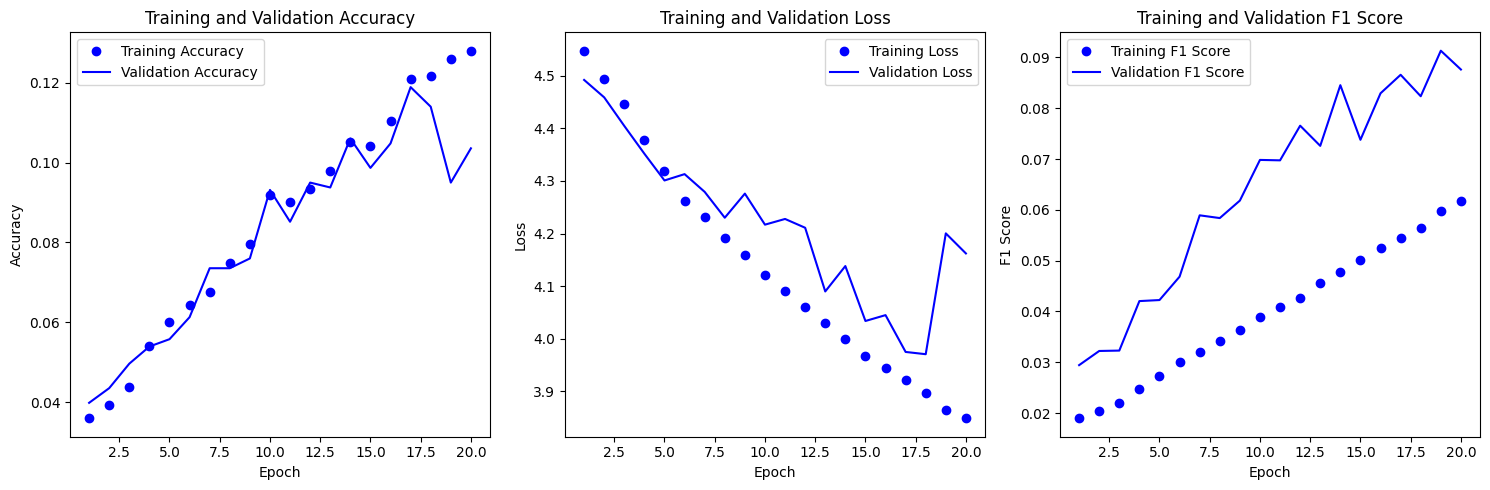

In [36]:
# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")

# model_path = os.path.join(models_dir, "classifier2.h5")
# history_path = os.path.join(models_dir, "classifier2_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})

# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)

# evaluate_model(classifier_loaded, train_generator15032, validation_generator15032, test_generator15032)

# training_plots_1(history_loaded)


### 8.1.2 150x150 and batch_size = 32 and batch_size = 64, Optimizer Adam

In [37]:
classifier3 = build_classifier1(optimizers.Adam(learning_rate=1e-4))
classifier4 = build_classifier1(optimizers.Adam(learning_rate=1e-4))

In [38]:
#CNN_s slide 100
history3 = classifier3.fit(
    train_generator15020,
    steps_per_epoch = 661, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15020,
    validation_steps = 82 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)

In [39]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier3.h5")
classifier3.save(model_path)
history_path = os.path.join(models_dir, "classifier3_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history3.history, f)

In [40]:
training_plots(history3)
evaluate_model(classifier3, train_generator15020, validation_generator15020, test_generator15020)


Training Loss: 3.588913679122925
Training Categorical Accuracy: 0.1688351035118103
Training Weighted F1-score: 0.09557948261499405
Validation Loss: 3.917024612426758
Validation Categorical Accuracy: 0.13672111928462982
Validation Weighted F1-score: 0.12100550532341003
Test Loss: 3.935534954071045
Test Categorical Accuracy: 0.14398063719272614
Test Weighted F1-score: 0.12314657121896744


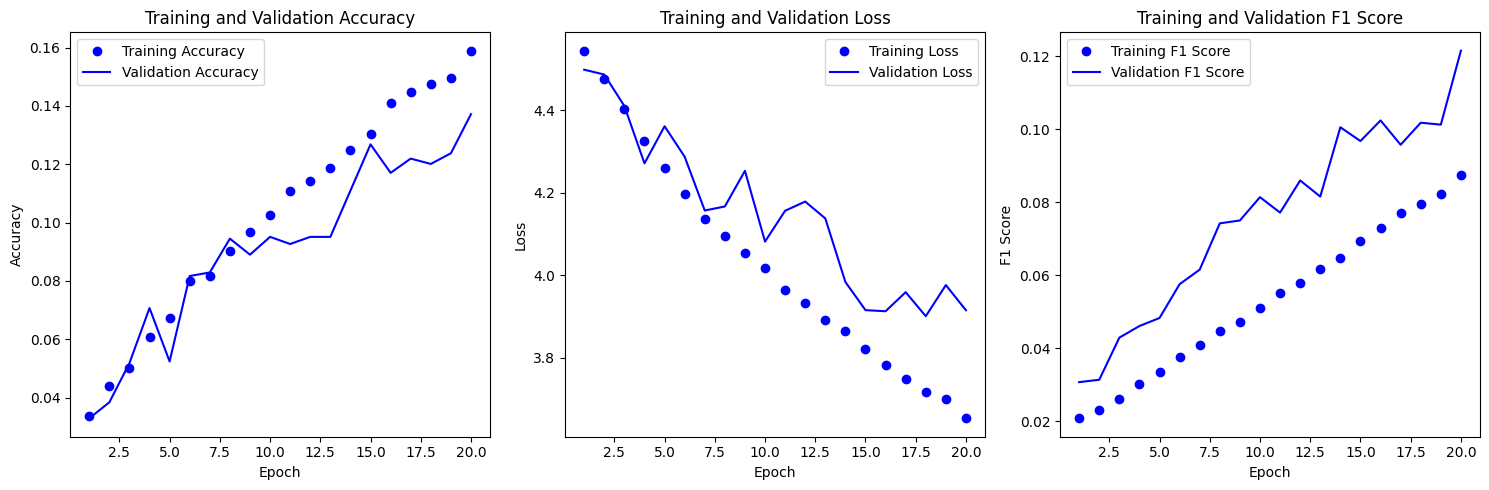

In [41]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "classifier3.h5")
# history_path = os.path.join(models_dir, "classifier3_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator15020, validation_generator15020, test_generator15020)


# training_plots_1(history_loaded)


In [42]:
#CNN_s slide 100
history4 = classifier4.fit(
    train_generator15032,
    steps_per_epoch = 413, #Calculated as the number of samples in the training set divided by the batch size, 13221/32 = 413.16
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15032,
    validation_steps = 51 #Calculated as the number of samples in the validation set divided by the batch size, 1653/32 = 51.65
)

In [43]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier4.h5")
classifier4.save(model_path)

history_path = os.path.join(models_dir, "classifier4_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history4.history, f)

In [44]:
evaluate_model(classifier4, train_generator15032, validation_generator15032, test_generator15032)
training_plots(history4)

Training Loss: 3.6849238872528076
Training Categorical Accuracy: 0.1511346399784088
Training Weighted F1-score: 0.07654298096895218
Validation Loss: 3.990752696990967
Validation Categorical Accuracy: 0.12522685527801514
Validation Weighted F1-score: 0.10169677436351776
Test Loss: 3.9885916709899902
Test Categorical Accuracy: 0.11917725205421448
Test Weighted F1-score: 0.1037730872631073


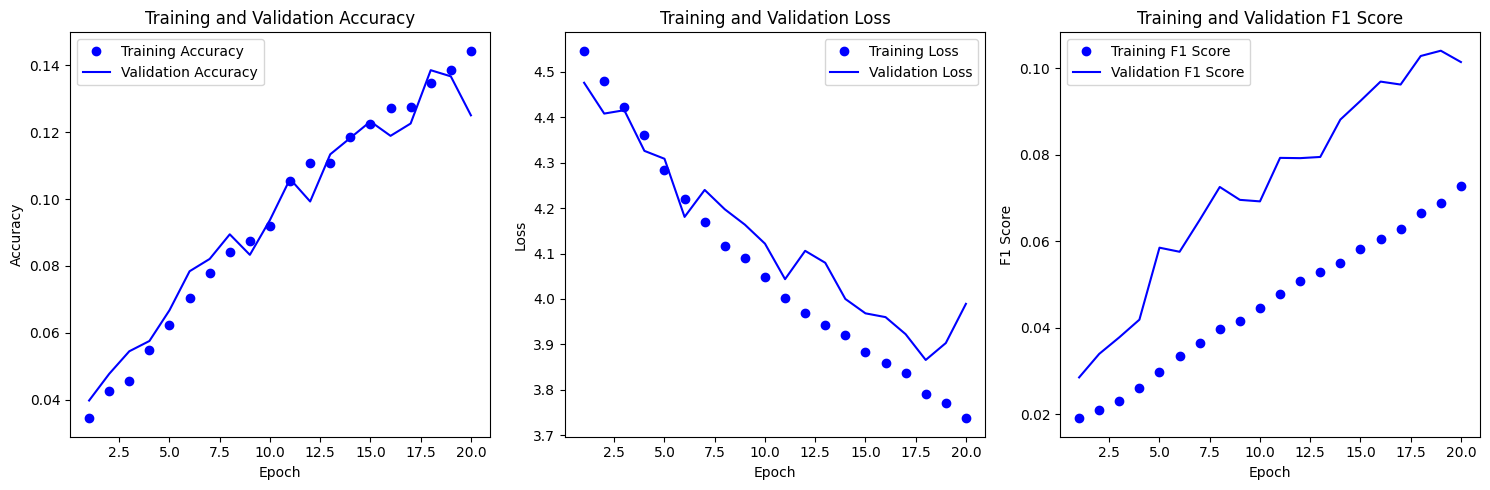

In [45]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "classifier4.h5")
# history_path = os.path.join(models_dir, "classifier4_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator15032, validation_generator15032, test_generator15032)

# training_plots_1(history_loaded)


## 8.2. ConvNet - 2nd try (5 layers)

In [46]:
def build_classifier2(optimizers):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(256, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(units=512, activation='relu'))
    classifier.add(Dense(units=114, activation='softmax'))
    classifier.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_metric])
    return classifier

In [47]:
classifier5 = build_classifier2(optimizers.RMSprop(learning_rate=1e-4))
classifier6 = build_classifier2(optimizers.RMSprop(learning_rate=1e-4))

### 8.2.1 150x150 and batch_size = 20 and batch_size = 32, Optimizer RMSProp 

In [48]:
history5 = classifier5.fit(
    train_generator15020,
    steps_per_epoch = 661, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15020,
    validation_steps = 82 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)

In [49]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier5.h5")
classifier5.save(model_path)

history_path = os.path.join(models_dir, "classifier5_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history5.history, f)

Training Loss: 3.9126813411712646
Training Categorical Accuracy: 0.11429651826620102
Training Weighted F1-score: 0.05602651461958885
Validation Loss: 4.030516147613525
Validation Categorical Accuracy: 0.0961887463927269
Validation Weighted F1-score: 0.07287699729204178
Test Loss: 4.038805961608887
Test Categorical Accuracy: 0.10647308081388474
Test Weighted F1-score: 0.0741649717092514


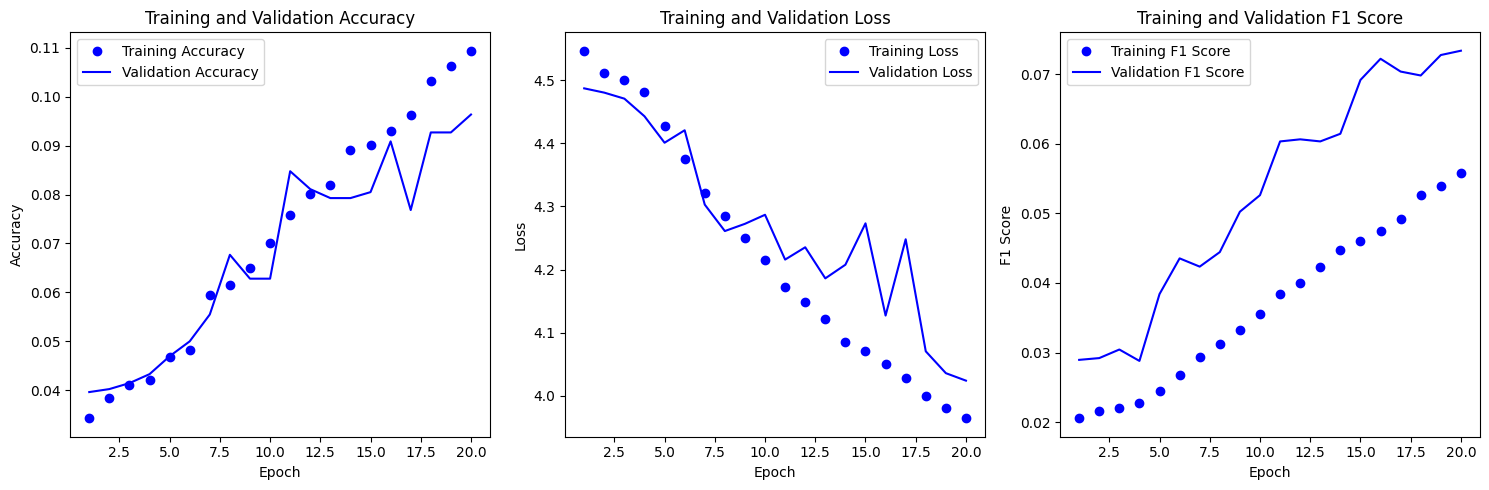

In [50]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "classifier5.h5")
# history_path = os.path.join(models_dir, "classifier5_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})

# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator15020, validation_generator15020, test_generator15020)

# training_plots_1(history_loaded)


In [51]:
training_plots(history5)
evaluate_model(classifier5, train_generator15020, validation_generator15020, test_generator15020)

In [52]:
#CNN_s slide 100
history6 = classifier6.fit(
    train_generator15032,
    steps_per_epoch = 413, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15032,
    validation_steps = 51 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)

In [53]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"


models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier6.h5")
classifier6.save(model_path)

history_path = os.path.join(models_dir, "classifier6_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history6.history, f)

Training Loss: 3.9411027431488037
Training Categorical Accuracy: 0.11180030554533005
Training Weighted F1-score: 0.05106061324477196
Validation Loss: 4.0825018882751465
Validation Categorical Accuracy: 0.10405323654413223
Validation Weighted F1-score: 0.07846080511808395
Test Loss: 4.087557315826416
Test Categorical Accuracy: 0.10526315867900848
Test Weighted F1-score: 0.08015896379947662


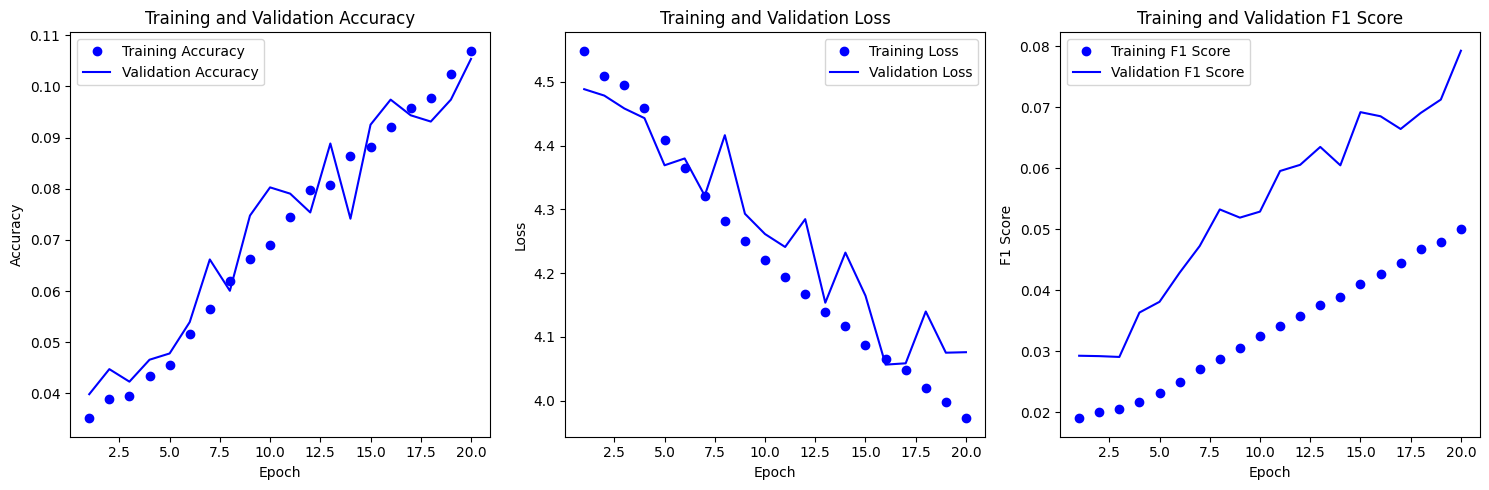

In [54]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "classifier6.h5")
# history_path = os.path.join(models_dir, "classifier6_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})

# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator15032, validation_generator15032, test_generator15032)


# training_plots_1(history_loaded)


In [55]:
training_plots(history6)
evaluate_model(classifier6, train_generator15032, validation_generator15032, test_generator15032)

### 8.2.2 150x150 and batch_size = 32 and batch_size = 64, Optimizer Adam

In [56]:
classifier7 = build_classifier2(optimizers.Adam(learning_rate=1e-4))
classifier8 = build_classifier2(optimizers.Adam(learning_rate=1e-4))

In [57]:
history7 = classifier7.fit(
    train_generator15020,
    steps_per_epoch = 661, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15020,
    validation_steps = 82 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)


In [58]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier7.h5")
classifier7.save(model_path)

history_path = os.path.join(models_dir, "classifier7_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history7.history, f)

Training Loss: 3.7457211017608643
Training Categorical Accuracy: 0.13434191048145294
Training Weighted F1-score: 0.07490507513284683
Validation Loss: 4.009246349334717
Validation Categorical Accuracy: 0.10949788242578506
Validation Weighted F1-score: 0.09748350828886032
Test Loss: 4.037480354309082
Test Categorical Accuracy: 0.11433757096529007
Test Weighted F1-score: 0.09895680844783783


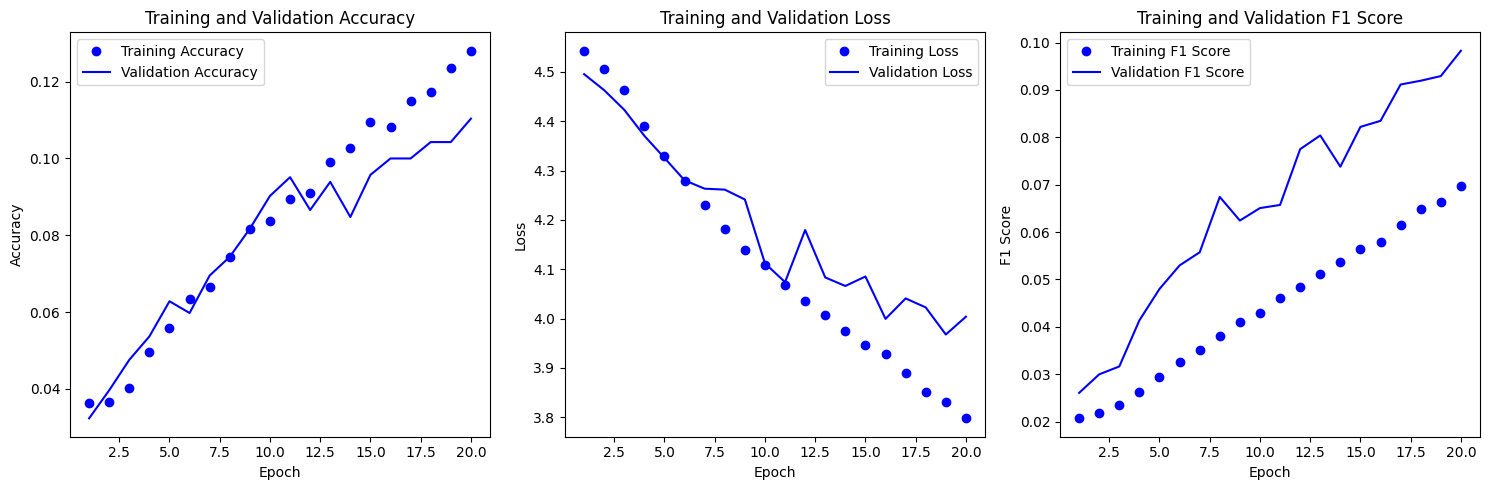

In [59]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")

# model_path = os.path.join(models_dir, "classifier7.h5")
# history_path = os.path.join(models_dir, "classifier7_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator15020, validation_generator15020, test_generator15020)


# training_plots_1(history_loaded)


In [60]:
training_plots(history7)
evaluate_model(classifier7, train_generator15020, validation_generator15020, test_generator15020)

In [61]:
history8 = classifier8.fit(
    train_generator15032,
    steps_per_epoch = 413, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15032,
    validation_steps = 51 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)


In [62]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"


models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier8.h5")
classifier8.save(model_path)
import pickle

history_path = os.path.join(models_dir, "classifier8_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history8.history, f)

Training Loss: 3.8394901752471924
Training Categorical Accuracy: 0.12723146378993988
Training Weighted F1-score: 0.06002318486571312
Validation Loss: 4.055759906768799
Validation Categorical Accuracy: 0.08832425624132156
Validation Weighted F1-score: 0.08587368577718735
Test Loss: 4.086874961853027
Test Categorical Accuracy: 0.10465819388628006
Test Weighted F1-score: 0.08700761198997498


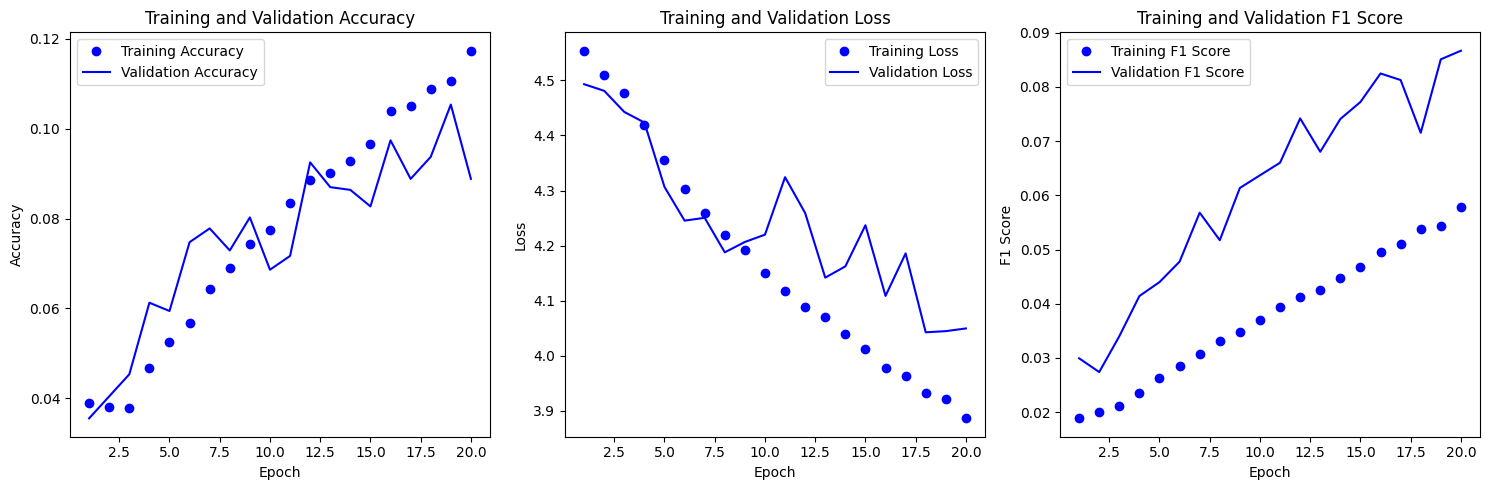

In [63]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "classifier8.h5")
# history_path = os.path.join(models_dir, "classifier8_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)

# evaluate_model(classifier_loaded, train_generator15032, validation_generator15032, test_generator15032)


# training_plots_1(history_loaded)


In [64]:
training_plots(history8)
evaluate_model(classifier8, train_generator15032, validation_generator15032, test_generator15032)

## 8.3 Best ConvNets with Dropouts

Now, the best model from both tests it's choosen and tested with dropout = 0.5 in order to reduce the overfitting.
If doesnt exist any improvements other (low) dropout value will be choosen.

Here we will use 50 epochs 

In [65]:
def build_classifier1(optimizers):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units=512, activation='relu'))
    classifier.add(Dense(units=114, activation='softmax'))
    classifier.compile(optimizer=optimizers, loss='categorical_crossentropy',  metrics=['categorical_accuracy', f1_metric])
    return classifier


In [66]:
classifier1_best_1 = build_classifier1(optimizers.Adam(learning_rate=1e-4))
classifier1_best_2 = build_classifier1(optimizers.Adam(learning_rate=1e-4))

In [67]:
#CNN_s slide 100
history1_best = classifier1_best_1.fit(
    train_generator15020,
    steps_per_epoch = 661, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15020,
    validation_steps = 82 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)

In [68]:
training_plots(history1_best)
evaluate_model(classifier1_best_1, train_generator15020, validation_generator15020, test_generator15020)

In [69]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier1_best.h5")
classifier1_best_1.save(model_path)

history_path = os.path.join(models_dir, "classifier1_best_1_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history1_best.history, f)

Training Loss: 3.619215726852417
Training Categorical Accuracy: 0.16323751211166382
Training Weighted F1-score: 0.08253903687000275
Validation Loss: 3.876371383666992
Validation Categorical Accuracy: 0.12220205366611481
Validation Weighted F1-score: 0.09718623012304306
Test Loss: 3.8939666748046875
Test Categorical Accuracy: 0.13006654381752014
Test Weighted F1-score: 0.09902829676866531


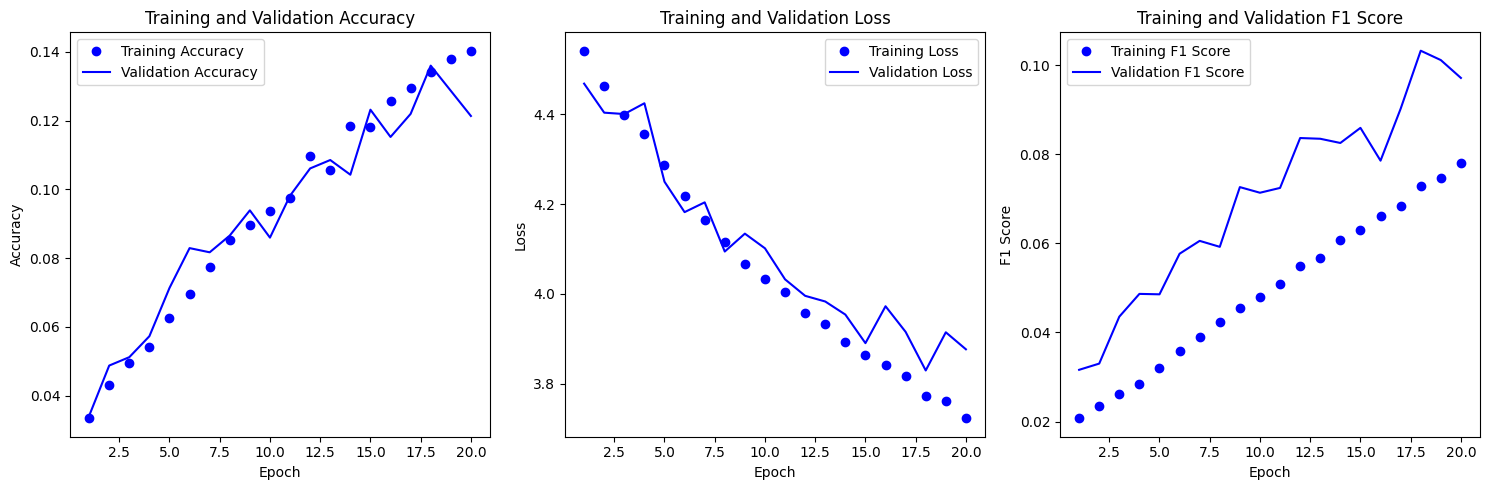

In [70]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")

# model_path = os.path.join(models_dir, "classifier1_best.h5")
# history_path = os.path.join(models_dir, "classifier1_best_1_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator15020, validation_generator15020, test_generator15020)

# training_plots_1(history_loaded)

In [71]:
#CNN_s slide 100
history2_best = classifier1_best_2.fit(
    train_generator15032,
    steps_per_epoch = 413, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15032,
    validation_steps = 51 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)



In [72]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"


models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier1_best_2.h5")
classifier1_best_2.save(model_path)

history_path = os.path.join(models_dir, "classifier1_best_2_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history2_best.history, f)

Training Loss: 3.668538808822632
Training Categorical Accuracy: 0.15756429731845856
Training Weighted F1-score: 0.07068603485822678
Validation Loss: 3.8343701362609863
Validation Categorical Accuracy: 0.13248638808727264
Validation Weighted F1-score: 0.098713718354702
Test Loss: 3.854342222213745
Test Categorical Accuracy: 0.1457955241203308
Test Weighted F1-score: 0.09893030673265457


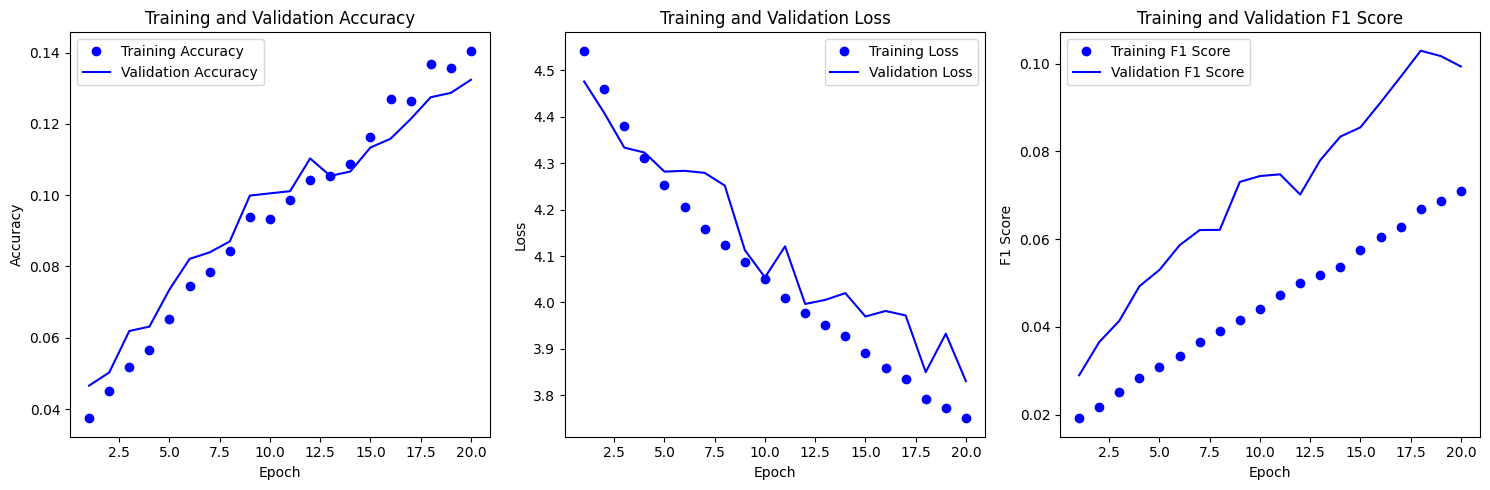

In [73]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "classifier1_best_2.h5")
# history_path = os.path.join(models_dir, "classifier1_best_2_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator15032, validation_generator15032, test_generator15032)

# training_plots_1(history_loaded)

In [74]:
training_plots(history2_best)
evaluate_model(classifier1_best_2, train_generator15032, validation_generator15032, test_generator15032)

In [75]:
def build_classifier2(optimizers):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dropout(0.3))
    classifier.add(Dense(units=512, activation='relu'))
    classifier.add(Dense(units=114, activation='softmax'))
    classifier.compile(optimizer=optimizers, loss='categorical_crossentropy',  metrics=['categorical_accuracy', f1_metric])
    return classifier

In [76]:
classifier_best_3 = build_classifier2(optimizers.Adam(learning_rate=1e-4))
classifier_best_4 = build_classifier2(optimizers.Adam(learning_rate=1e-4))

In [77]:
history_best_3 = classifier_best_3.fit(
    train_generator15020,
    steps_per_epoch = 661, #Calculated as the number of samples in the training set divided by the batch size, 13221/20 = 661.05
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15020,
    validation_steps = 82 #Calculated as the number of samples in the validation set divided by the batch size, 1653/20 = 82.65
)


In [78]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"


models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier_best_3.h5")
classifier_best_3.save(model_path)

history_path = os.path.join(models_dir, "classifier_best_3_history.pkl")


with open(history_path, 'wb') as f:
    pickle.dump(history_best_3.history, f)

Training Loss: 3.5997250080108643
Training Categorical Accuracy: 0.16535551846027374
Training Weighted F1-score: 0.08641975373029709
Validation Loss: 3.9268133640289307
Validation Categorical Accuracy: 0.13067150115966797
Validation Weighted F1-score: 0.1041002869606018
Test Loss: 3.944688558578491
Test Categorical Accuracy: 0.13430127501487732
Test Weighted F1-score: 0.10504412651062012


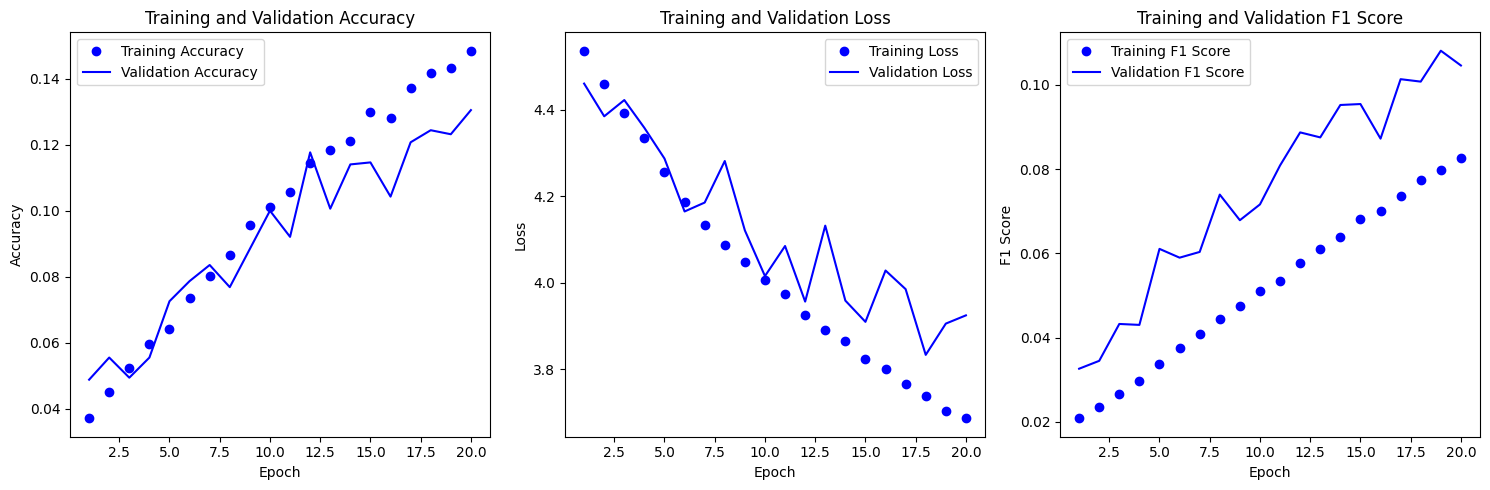

In [79]:

project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
models_dir = os.path.join(project_dir, "models1")


model_path = os.path.join(models_dir, "classifier_best_3.h5")
history_path = os.path.join(models_dir, "classifier_best_3_history.pkl")


classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


with open(history_path, 'rb') as file:
    history_loaded = pickle.load(file)

evaluate_model(classifier_loaded, train_generator15020, validation_generator15020, test_generator15020)


training_plots_1(history_loaded)

In [80]:
training_plots(history_best_3)
evaluate_model(classifier_best_3, train_generator15020, validation_generator15020, test_generator15020)


In [81]:
history_best_4 = classifier_best_4.fit(
    train_generator15032,
    steps_per_epoch = 413, #Calculated as the number of samples in the training set divided by the batch size, 13221/32 = 413.16
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator15032,
    validation_steps = 51 #Calculated as the number of samples in the validation set divided by the batch size, 1653/32 = 51.65
)

In [82]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "classifier_best_4.h5")
classifier_best_4.save(model_path)

history_path = os.path.join(models_dir, "classifier_best_4_history.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(history_best_4.history, f)

Training Loss: 3.6224136352539062
Training Categorical Accuracy: 0.16104386746883392
Training Weighted F1-score: 0.08435159176588058
Validation Loss: 3.9303295612335205
Validation Categorical Accuracy: 0.1336963027715683
Validation Weighted F1-score: 0.11416658759117126
Test Loss: 3.9795148372650146
Test Categorical Accuracy: 0.13248638808727264
Test Weighted F1-score: 0.11445119976997375


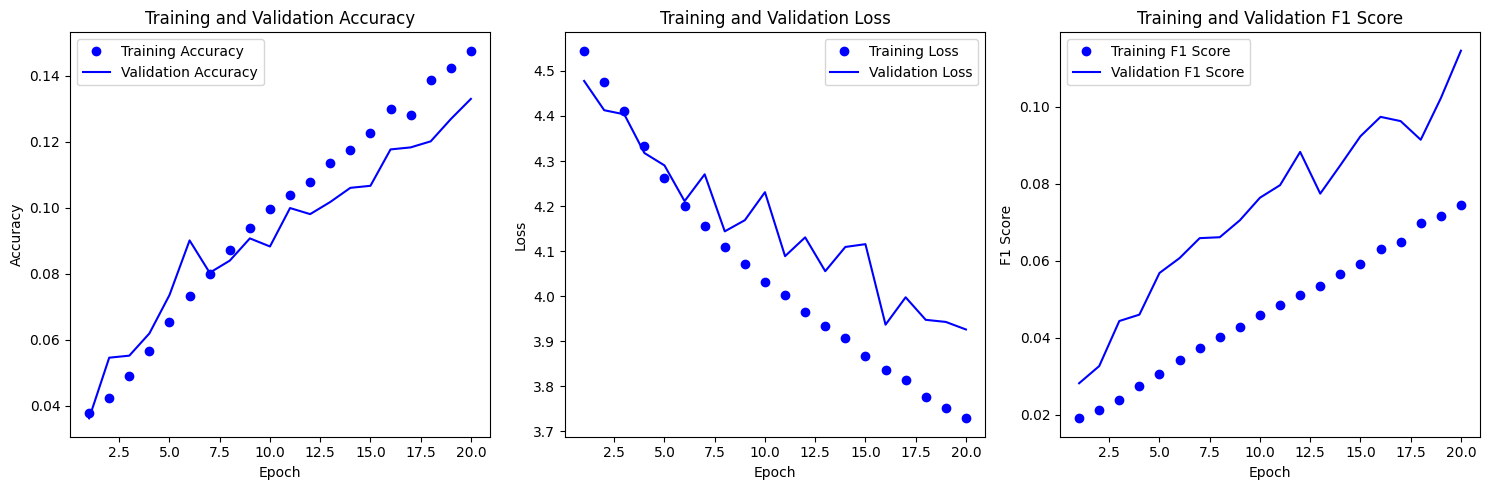

In [83]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "classifier_best_4.h5")
# history_path = os.path.join(models_dir, "classifier_best_4_history.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator15032, validation_generator15032, test_generator15032)

# training_plots_1(history_loaded)

In [84]:
training_plots(history_best_4)
evaluate_model(classifier_best_4, train_generator15032, validation_generator15032, test_generator15032)

## 8.4 AlexNet

https://www.coursera.org/lecture/convolutional-neural-networks/classic-networks-MmYe2
https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [85]:
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)))
model1.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model1.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model1.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model1.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model1.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model1.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
model1.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(4096, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(4096, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(114, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['categorical_accuracy', f1_metric])

In [86]:
historyalex1 = model1.fit(
    train_generator22464,
    steps_per_epoch = 206,
    epochs = 20,
    callbacks = callbacks_list,
    validation_data = validation_generator22464,
    validation_steps = 25
)

In [87]:
training_plots(historyalex1)
evaluate_model(model1, train_generator22464, validation_generator22464, test_generator22464)

In [88]:
project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"

models_dir = os.path.join(project_dir, "models1")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, "model_alex_224.h5")
model1.save(model_path)

history_path = os.path.join(models_dir, "model_alex_history_224.pkl")

with open(history_path, 'wb') as f:
    pickle.dump(historyalex1.history, f)

Training Loss: 4.502842426300049
Training Categorical Accuracy: 0.03956127166748047
Training Weighted F1-score: 0.017642375081777573
Validation Loss: 4.500917434692383
Validation Categorical Accuracy: 0.039322443306446075
Validation Weighted F1-score: 0.026318026706576347
Test Loss: 4.501776695251465
Test Categorical Accuracy: 0.039322443306446075
Test Weighted F1-score: 0.02629709430038929


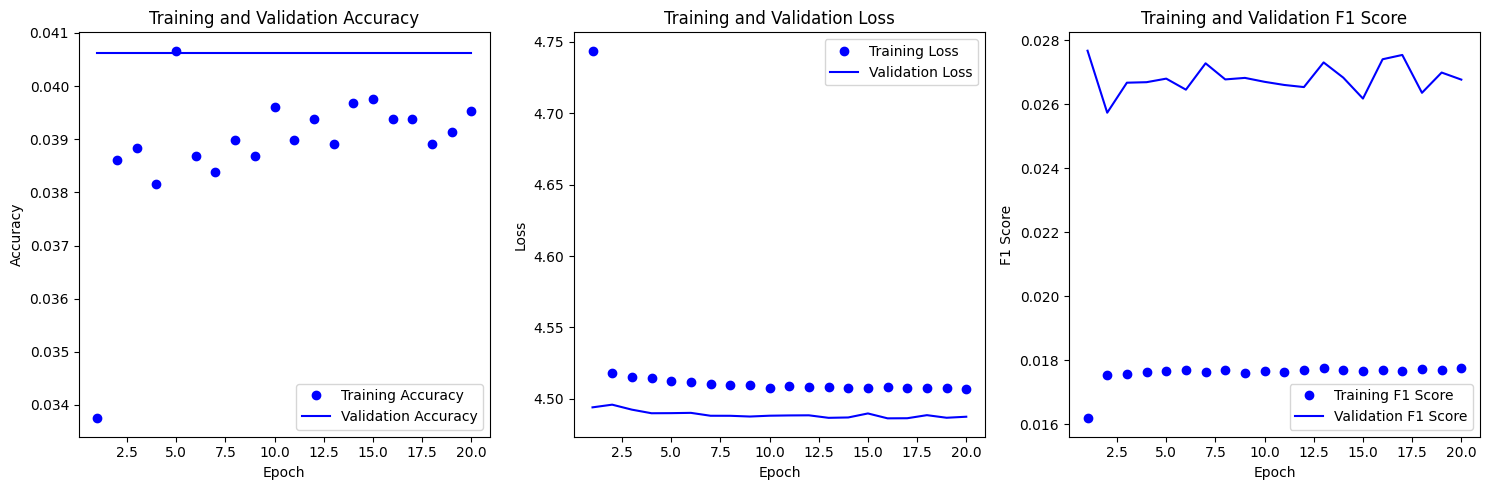

In [89]:

# project_dir = "c:\\Users\\carla\\OneDrive\\Ambiente de Trabalho\\DL\\Project"
# models_dir = os.path.join(project_dir, "models1")


# model_path = os.path.join(models_dir, "model_alex_224.h5")
# history_path = os.path.join(models_dir, "model_alex_history_224.pkl")


# classifier_loaded = load_model(model_path, custom_objects={'f1_metric': f1_metric})


# with open(history_path, 'rb') as file:
#     history_loaded = pickle.load(file)


# evaluate_model(classifier_loaded, train_generator22464, validation_generator22464, test_generator22464)


# training_plots_1(history_loaded)